In [1]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

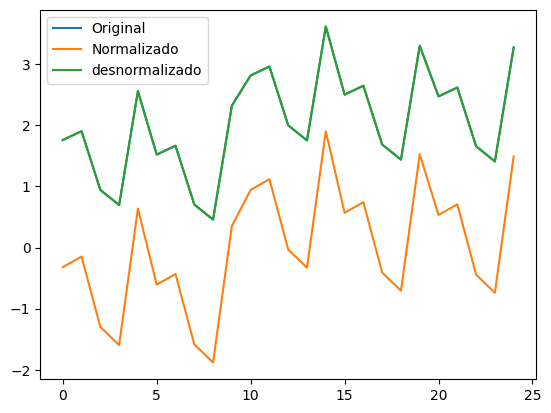

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:24:58.309625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:24:58.313861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:24:58.329123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753136698.365571    1983 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753136698.379449    1983 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753136698.412890    1983 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_training_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.794335,0.526006,0.560415,0.050196,0.143445,0.281383,0.374412,0.122242,0.247874,0.378741,5.935963,0.394865,53.883608,84.355503
model_1_1_8,0.790290,0.523898,0.558527,0.033945,0.146266,0.282634,0.376020,0.124334,0.250245,0.382448,6.033040,0.398729,53.844655,84.316550
model_1_1_7,0.786177,0.521399,0.556049,0.017837,0.149135,0.284118,0.378131,0.126407,0.252646,0.386180,6.131753,0.402620,53.805809,84.277704
model_1_1_4,0.773974,0.520907,0.561667,-0.032070,0.157646,0.284410,0.373346,0.132830,0.259372,0.397047,6.424633,0.413950,53.694803,84.166698
model_1_1_6,0.782029,0.519674,0.555036,0.001729,0.152028,0.285142,0.378994,0.128480,0.255028,0.389907,6.231295,0.406506,53.767385,84.239281
model_1_1_5,0.777793,0.517563,0.553417,-0.015006,0.154982,0.286395,0.380373,0.130634,0.257439,0.393678,6.332968,0.410438,53.728887,84.200783
model_1_1_3,0.746984,0.517187,0.566709,-0.201252,0.176471,0.286619,0.369052,0.154605,0.271864,0.420084,7.072387,0.437968,53.469200,83.941095
model_1_1_2,0.741961,0.513715,0.563330,-0.222936,0.179974,0.288680,0.371929,0.157395,0.274539,0.424234,7.192942,0.442294,53.429883,83.901778
model_1_1_1,0.736711,0.510928,0.561301,-0.248613,0.183636,0.290334,0.373658,0.160700,0.277280,0.428528,7.318945,0.446771,53.389599,83.861495
model_1_1_0,0.726061,0.504476,0.556070,-0.297130,0.191064,0.294164,0.378114,0.166944,0.282804,0.437108,7.574529,0.455717,53.310297,83.782193


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.860258,0.564153,0.594816,0.827667,0.097466,0.258738,0.345112,0.084382,0.202842,0.312195,4.353805,0.325486,54.656513,85.128408
model_1_2_8,0.857389,0.562915,0.593760,0.824009,0.099467,0.259473,0.346011,0.086174,0.204807,0.315384,4.422667,0.328810,54.615863,85.087759
model_1_2_7,0.854509,0.561360,0.592132,0.820496,0.101476,0.260396,0.347398,0.087894,0.206803,0.318552,4.491792,0.332114,54.575873,85.047769
model_1_2_6,0.848984,0.559633,0.591319,0.813763,0.105329,0.261421,0.348090,0.091191,0.210290,0.324544,4.624388,0.338361,54.501333,84.973228
model_1_2_5,0.833235,0.555303,0.591950,0.788750,0.116313,0.263991,0.347553,0.103438,0.221133,0.341047,5.002352,0.355566,54.302939,84.774835
model_1_2_4,0.832522,0.551752,0.588750,0.787596,0.116811,0.266099,0.350278,0.104003,0.223775,0.341776,5.019477,0.356326,54.294400,84.766295
model_1_2_3,0.829162,0.549981,0.587158,0.783373,0.119154,0.267151,0.351634,0.106071,0.225909,0.345187,5.100115,0.359883,54.254673,84.726569
model_1_2_2,0.806267,0.533594,0.567462,0.747811,0.135122,0.276879,0.368411,0.123484,0.240747,0.367590,5.649582,0.383239,54.003149,84.475044
model_1_2_1,0.802390,0.531161,0.565018,0.742669,0.137827,0.278323,0.370492,0.126002,0.243113,0.371251,5.742650,0.387056,53.963511,84.435407
model_1_2_0,0.798412,0.528816,0.562766,0.737338,0.140601,0.279715,0.372410,0.128612,0.245501,0.374968,5.838110,0.390931,53.923655,84.395551


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.885730,0.584142,0.621215,0.862004,0.079700,0.246871,0.322627,0.087532,0.183873,0.282312,3.742485,0.294330,55.058974,85.530870
model_1_3_8,0.883457,0.583749,0.621413,0.859383,0.081285,0.247104,0.322458,0.089194,0.185470,0.285105,3.797033,0.297243,55.019585,85.491480
model_1_3_7,0.881280,0.582721,0.620113,0.857076,0.082804,0.247715,0.323565,0.090658,0.186747,0.287756,3.849285,0.300007,54.982567,85.454463
model_1_3_6,0.878907,0.582036,0.619937,0.854259,0.084459,0.248122,0.323715,0.092445,0.188457,0.290618,3.906237,0.302990,54.942985,85.414881
model_1_3_5,0.876505,0.581966,0.620901,0.851462,0.086134,0.248163,0.322894,0.094219,0.190087,0.293486,3.963887,0.305980,54.903700,85.375596
model_1_3_4,0.874049,0.581733,0.621655,0.848534,0.087847,0.248301,0.322252,0.096076,0.191826,0.296390,4.022823,0.309008,54.864321,85.336216
model_1_3_2,0.868996,0.581330,0.623125,0.842731,0.091371,0.248541,0.321000,0.099757,0.195170,0.302277,4.144094,0.315145,54.785652,85.257547
model_1_3_3,0.871527,0.581297,0.621969,0.845608,0.089606,0.248560,0.321985,0.097932,0.193544,0.299343,4.083358,0.312086,54.824665,85.296561
model_1_3_1,0.865652,0.569244,0.600991,0.836695,0.093704,0.255716,0.339853,0.103586,0.198604,0.306111,4.224358,0.319142,54.735236,85.207131
model_1_3_0,0.863019,0.566840,0.598275,0.833292,0.095540,0.257142,0.342166,0.105744,0.200769,0.309096,4.287553,0.322255,54.696416,85.168312


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.915355,0.607191,0.656505,0.900985,0.059038,0.233188,0.292568,0.087541,0.157962,0.242976,3.031491,0.253320,55.659163,86.131059
model_1_4_8,0.913800,0.605941,0.654496,0.899621,0.060122,0.233930,0.294280,0.088746,0.159452,0.245198,3.068812,0.255637,55.622755,86.094650
model_1_4_7,0.912335,0.605072,0.653153,0.898489,0.061143,0.234446,0.295424,0.089748,0.160807,0.247272,3.103949,0.257798,55.589071,86.060967
model_1_4_6,0.910839,0.604412,0.652164,0.897422,0.062187,0.234838,0.296266,0.090692,0.162248,0.249373,3.139855,0.259989,55.555227,86.027123
model_1_4_5,0.907620,0.602219,0.648808,0.894922,0.064432,0.236140,0.299125,0.092901,0.165233,0.253834,3.217112,0.264641,55.484292,85.956188
model_1_4_4,0.905988,0.600718,0.646346,0.893688,0.065570,0.237031,0.301221,0.093992,0.166747,0.256067,3.256284,0.266968,55.449265,85.921161
model_1_4_3,0.904316,0.598816,0.643269,0.892286,0.066737,0.238160,0.303842,0.095231,0.168203,0.258334,3.296414,0.269332,55.414006,85.885902
model_1_4_2,0.902597,0.597394,0.641021,0.890901,0.067936,0.239005,0.305757,0.096457,0.169763,0.260645,3.337681,0.271741,55.378385,85.850280
model_1_4_1,0.900876,0.596134,0.639109,0.889617,0.069136,0.239752,0.307386,0.097592,0.171302,0.262938,3.378987,0.274131,55.343354,85.815249
model_1_4_0,0.887737,0.585767,0.623600,0.878871,0.078300,0.245907,0.320595,0.107092,0.182219,0.279822,3.694323,0.291734,55.094409,85.566305


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.930547,0.617894,0.671090,0.901914,0.048441,0.226835,0.280146,0.037064,0.143502,0.220094,2.666874,0.229464,56.054803,86.526698
model_1_5_8,0.929154,0.617670,0.671170,0.900034,0.049413,0.226968,0.280078,0.037775,0.144879,0.222290,2.700304,0.231753,56.015089,86.486985
model_1_5_6,0.926339,0.615889,0.668803,0.896202,0.051376,0.228025,0.282094,0.039223,0.147571,0.226663,2.767864,0.236313,55.937160,86.409055
model_1_5_7,0.927785,0.615477,0.667564,0.897903,0.050367,0.228270,0.283150,0.038580,0.146287,0.224427,2.733150,0.233981,55.976822,86.448718
model_1_5_5,0.924854,0.615024,0.667719,0.894172,0.052412,0.228538,0.283017,0.039990,0.148996,0.228937,2.803514,0.238684,55.897229,86.369125
model_1_5_4,0.923370,0.614192,0.666703,0.892191,0.053447,0.229032,0.283883,0.040738,0.150422,0.231185,2.839109,0.241027,55.858141,86.330037
model_1_5_3,0.921833,0.612816,0.664699,0.890176,0.054519,0.229849,0.285589,0.041500,0.151902,0.233492,2.875996,0.243433,55.818424,86.290319
model_1_5_2,0.920268,0.610980,0.661821,0.888115,0.055611,0.230939,0.288041,0.042279,0.153420,0.235820,2.913579,0.245859,55.778753,86.250648
model_1_5_1,0.918657,0.609911,0.660424,0.885977,0.056734,0.231574,0.289231,0.043086,0.154922,0.238189,2.952232,0.248330,55.738756,86.210652
model_1_5_0,0.917025,0.608701,0.658764,0.883870,0.057872,0.232292,0.290644,0.043883,0.156424,0.240566,2.991391,0.250808,55.699037,86.170932


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  15
1/1 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.931717,0.617807,0.670861,0.875918,0.047625,0.226886,0.280341,0.047695,0.142214,0.218231,2.638780,0.227522,56.088799,86.560694
model_1_6_1,0.933849,0.615998,0.666967,0.876187,0.046139,0.227960,0.283658,0.047592,0.139763,0.214799,2.587635,0.223943,56.152212,86.624108
model_1_6_2,0.934901,0.615259,0.665212,0.876357,0.045404,0.228399,0.285153,0.047526,0.138470,0.213083,2.562375,0.222155,56.184289,86.656185
model_1_6_3,0.936834,0.613919,0.662116,0.875886,0.044056,0.229195,0.287790,0.047707,0.136022,0.209896,2.515981,0.218831,56.244577,86.716473
model_1_6_4,0.944000,0.598949,0.634940,0.870068,0.039058,0.238081,0.310936,0.049944,0.127129,0.197632,2.344007,0.206046,56.485393,86.957288
model_1_6_5,0.944752,0.598309,0.633665,0.869398,0.038533,0.238461,0.312023,0.050201,0.125984,0.196299,2.325941,0.204656,56.512459,86.984355
model_1_6_6,0.945506,0.597619,0.632322,0.869115,0.038008,0.238871,0.313167,0.050310,0.124928,0.194956,2.307854,0.203256,56.539928,87.011824
model_1_6_7,0.947000,0.596582,0.630283,0.868203,0.036966,0.239487,0.314903,0.050661,0.122646,0.192266,2.272007,0.200451,56.595511,87.067407
model_1_6_8,0.947747,0.595518,0.628100,0.868203,0.036445,0.240118,0.316762,0.050661,0.121550,0.190906,2.254080,0.199033,56.623899,87.095795
model_1_6_9,0.949083,0.594150,0.625694,0.867058,0.035513,0.240930,0.318811,0.051101,0.119486,0.188449,2.222009,0.196472,56.675711,87.147606


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.956502,0.607923,0.655489,0.917668,0.030338,0.232754,0.293434,0.039815,0.116213,0.174179,2.043950,0.181594,56.990681,87.462576
model_1_7_7,0.954827,0.607418,0.654681,0.914280,0.031507,0.233054,0.294122,0.041454,0.118532,0.177501,2.084151,0.185058,56.915108,87.387004
model_1_7_6,0.953923,0.606965,0.654003,0.912632,0.032137,0.233323,0.294700,0.042250,0.119740,0.179269,2.105852,0.186901,56.875471,87.347367
model_1_7_5,0.953007,0.606719,0.653715,0.910985,0.032776,0.233468,0.294945,0.043047,0.120947,0.181042,2.127829,0.188749,56.836113,87.308009
model_1_7_8,0.955764,0.606544,0.653098,0.916887,0.030853,0.233572,0.295471,0.040193,0.117171,0.175650,2.061656,0.183128,56.957043,87.428938
model_1_7_4,0.953444,0.601322,0.638891,0.918888,0.032472,0.236672,0.307571,0.039225,0.114570,0.180199,2.117350,0.187870,56.854784,87.326680
model_1_7_3,0.952688,0.600939,0.638539,0.918292,0.032998,0.236900,0.307871,0.039513,0.115217,0.181655,2.135480,0.189388,56.822593,87.294488
model_1_7_2,0.951730,0.600710,0.638182,0.916652,0.033667,0.237036,0.308175,0.040307,0.116410,0.183486,2.158486,0.191297,56.782476,87.254372
model_1_7_1,0.951026,0.595876,0.628818,0.916453,0.034158,0.239905,0.316151,0.040403,0.117174,0.184818,2.175366,0.192686,56.753544,87.225440
model_1_7_0,0.950073,0.594881,0.626986,0.915039,0.034823,0.240496,0.317711,0.041086,0.118330,0.186608,2.198248,0.194552,56.714982,87.186877


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.963993,0.626812,0.688893,0.962535,0.025114,0.221540,0.264983,0.037720,0.105640,0.158474,1.864172,0.165220,57.368671,87.840567
model_1_8_8,0.963300,0.625775,0.687302,0.961892,0.025597,0.222156,0.266338,0.038368,0.106654,0.159991,1.880802,0.166802,57.330549,87.802444
model_1_8_7,0.962587,0.623899,0.684095,0.961182,0.026095,0.223270,0.269069,0.039082,0.107629,0.161538,1.897919,0.168415,57.292055,87.763951
model_1_8_6,0.961914,0.622224,0.681102,0.960608,0.026564,0.224264,0.271618,0.039660,0.108586,0.162985,1.914070,0.169923,57.256400,87.728295
model_1_8_5,0.961244,0.619957,0.676684,0.960190,0.027031,0.225610,0.275381,0.040081,0.109549,0.164411,1.930136,0.171410,57.221551,87.693447
model_1_8_4,0.960457,0.617523,0.672844,0.959346,0.027580,0.227055,0.278652,0.040931,0.110716,0.166073,1.949041,0.173143,57.181311,87.653206
model_1_8_3,0.959692,0.614792,0.667925,0.958627,0.028114,0.228676,0.282842,0.041655,0.111906,0.167671,1.967395,0.174809,57.143001,87.614896
model_1_8_2,0.958924,0.613061,0.664702,0.957868,0.028649,0.229704,0.285587,0.042419,0.112861,0.169261,1.985822,0.176466,57.105261,87.577157
model_1_8_1,0.958132,0.611556,0.662021,0.957125,0.029202,0.230597,0.287870,0.043166,0.113996,0.170886,2.004841,0.178160,57.067045,87.538941
model_1_8_0,0.957329,0.609871,0.659006,0.956370,0.029762,0.231597,0.290439,0.043927,0.115104,0.172516,2.024102,0.179860,57.029070,87.500966


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_4,0.968807,0.634998,0.705397,0.976018,0.021756,0.216681,0.250926,0.013030,0.098678,0.147500,1.748639,0.153780,57.655701,88.127597
model_1_9_7,0.970316,0.634453,0.705718,0.977530,0.020704,0.217005,0.250652,0.012209,0.097113,0.143888,1.712422,0.150014,57.754872,88.226768
model_1_9_5,0.969088,0.634077,0.704998,0.976519,0.021560,0.217228,0.251265,0.012758,0.099098,0.146833,1.741881,0.153084,57.673836,88.145732
model_1_9_6,0.969719,0.634032,0.705260,0.977113,0.021120,0.217254,0.251042,0.012435,0.098091,0.145326,1.726732,0.151513,57.715098,88.186994
model_1_9_3,0.968197,0.633406,0.702850,0.975595,0.022181,0.217626,0.253095,0.013260,0.099559,0.148934,1.763265,0.155275,57.617002,88.088898
model_1_9_2,0.967546,0.633271,0.702442,0.975049,0.022636,0.217706,0.253443,0.013557,0.100479,0.150452,1.778902,0.156857,57.576443,88.048338
model_1_9_8,0.972603,0.626887,0.694278,0.979787,0.019108,0.221496,0.260396,0.010983,0.093181,0.138233,1.657521,0.144118,57.915262,88.387157
model_1_9_9,0.974420,0.617340,0.680899,0.981909,0.017841,0.227164,0.271791,0.009829,0.091325,0.133571,1.613920,0.139258,58.052483,88.524379
model_1_9_1,0.967263,0.615825,0.672847,0.973808,0.022833,0.228063,0.278650,0.014231,0.101060,0.151107,1.785695,0.157540,57.559076,88.030972
model_1_9_0,0.966596,0.614960,0.671363,0.973239,0.023299,0.228577,0.279913,0.014540,0.102051,0.152638,1.801705,0.159137,57.518733,87.990628


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.979555,0.625738,0.696114,0.973346,0.014260,0.222178,0.258832,0.005112,0.081465,0.119415,1.490690,0.124499,58.500589,88.972485
model_1_10_8,0.978714,0.623274,0.691535,0.971926,0.014846,0.223641,0.262733,0.005384,0.083180,0.121844,1.510855,0.127032,58.420044,88.891939
model_1_10_7,0.978274,0.622378,0.689928,0.971218,0.015153,0.224173,0.264101,0.005520,0.084055,0.123098,1.521418,0.128338,58.379112,88.851007
model_1_10_6,0.977824,0.621558,0.688469,0.970476,0.015467,0.224659,0.265344,0.005662,0.084942,0.124368,1.532235,0.129663,58.338043,88.809938
model_1_10_5,0.977367,0.620824,0.687158,0.969755,0.015786,0.225095,0.266460,0.005801,0.085815,0.125643,1.543200,0.130991,58.297257,88.769153
model_1_10_4,0.976899,0.619938,0.685566,0.968968,0.016112,0.225621,0.267817,0.005952,0.086721,0.126933,1.554420,0.132337,58.256370,88.728265
model_1_10_3,0.976423,0.619051,0.683985,0.968186,0.016444,0.226148,0.269163,0.006102,0.087626,0.128234,1.565843,0.133694,58.215581,88.687477
model_1_10_2,0.975938,0.618191,0.682477,0.967377,0.016783,0.226658,0.270447,0.006257,0.088540,0.129548,1.577492,0.135063,58.174823,88.646719
model_1_10_1,0.975445,0.617409,0.681093,0.966576,0.017126,0.227123,0.271626,0.006410,0.089456,0.130867,1.589312,0.136438,58.134304,88.606199
model_1_10_0,0.974937,0.616486,0.679464,0.965727,0.017481,0.227670,0.273014,0.006573,0.090392,0.132214,1.601508,0.137843,58.093333,88.565229


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.984513,0.650738,0.737751,0.978737,0.010802,0.207337,0.223368,0.015988,0.070771,0.103931,1.371688,0.108356,59.056104,89.527999
model_1_11_8,0.983851,0.648702,0.734077,0.977688,0.011264,0.208546,0.226498,0.016776,0.072317,0.106130,1.387580,0.110648,58.972370,89.444266
model_1_11_7,0.982818,0.640754,0.720583,0.976459,0.011984,0.213264,0.237991,0.017701,0.074263,0.109471,1.412371,0.114132,58.848369,89.320265
model_1_11_6,0.982453,0.638604,0.717175,0.975845,0.012238,0.214540,0.240893,0.018162,0.075110,0.110627,1.421123,0.115337,58.806366,89.278262
model_1_11_5,0.982068,0.637071,0.714696,0.975199,0.012507,0.215451,0.243005,0.018648,0.075996,0.111834,1.430365,0.116595,58.762947,89.234843
model_1_11_4,0.981676,0.635188,0.711709,0.974572,0.012780,0.216568,0.245549,0.019120,0.076868,0.113049,1.439768,0.117862,58.719720,89.191615
model_1_11_3,0.981268,0.633405,0.708767,0.973894,0.013065,0.217627,0.248055,0.019629,0.077769,0.114303,1.449571,0.119169,58.675626,89.147522
model_1_11_2,0.980838,0.631112,0.705025,0.973158,0.013365,0.218988,0.251242,0.020183,0.078722,0.115606,1.459882,0.120528,58.630272,89.102168
model_1_11_1,0.980420,0.628936,0.701450,0.972446,0.013656,0.220279,0.254287,0.020718,0.079626,0.116860,1.469914,0.121835,58.587116,89.059012
model_1_11_0,0.979992,0.627533,0.699135,0.971736,0.013955,0.221112,0.256259,0.021252,0.080538,0.118132,1.480202,0.123162,58.543798,89.015694


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.984787,0.643830,0.726415,0.984354,0.010611,0.211438,0.233023,0.007853,0.069862,0.103009,1.365119,0.107394,59.091766,89.563661
model_1_12_1,0.985027,0.642533,0.724749,0.984658,0.010443,0.212208,0.234443,0.007700,0.069363,0.102191,1.359348,0.106542,59.123631,89.595527
model_1_12_7,0.988565,0.610138,0.669951,0.989132,0.007976,0.231439,0.281116,0.005454,0.058413,0.089308,1.274451,0.093110,59.662666,90.134562
model_1_12_8,0.989289,0.608871,0.671254,0.989125,0.007471,0.232191,0.280006,0.005458,0.052078,0.086434,1.257071,0.090113,59.793510,90.265406
model_1_12_5,0.988252,0.606766,0.661625,0.988759,0.008194,0.233441,0.288208,0.005641,0.058294,0.090521,1.281957,0.094374,59.608702,90.080598
model_1_12_2,0.987589,0.606661,0.661205,0.988191,0.008656,0.233503,0.288566,0.005927,0.060166,0.093039,1.297866,0.097000,59.498927,89.970823
model_1_12_6,0.988473,0.606595,0.661466,0.988933,0.008040,0.233542,0.288343,0.005554,0.057695,0.089666,1.276657,0.093483,59.646659,90.118554
model_1_12_3,0.987827,0.606003,0.659985,0.988446,0.008490,0.233894,0.289605,0.005799,0.059602,0.092143,1.292156,0.096066,59.537640,90.009536
model_1_12_4,0.988053,0.605486,0.659115,0.988626,0.008333,0.234200,0.290346,0.005708,0.059005,0.091283,1.286728,0.095170,59.575144,90.047040
model_1_12_9,0.989299,0.603447,0.662832,0.989170,0.007464,0.235411,0.287180,0.005435,0.055859,0.086392,1.256823,0.090070,59.795437,90.267333


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.991179,0.613377,0.681332,0.986552,0.006152,0.229516,0.271423,0.001807,0.050661,0.078437,1.211702,0.081776,60.181858,90.653754
model_1_13_8,0.991002,0.612956,0.680538,0.986365,0.006276,0.229766,0.272099,0.001832,0.051202,0.079221,1.215958,0.082594,60.142049,90.613945
model_1_13_7,0.990832,0.612300,0.679316,0.986261,0.006395,0.230156,0.273139,0.001846,0.051668,0.079966,1.220037,0.083370,60.104627,90.576523
model_1_13_6,0.990650,0.611591,0.678003,0.986090,0.006521,0.230576,0.274258,0.001869,0.052172,0.080755,1.224400,0.084193,60.065358,90.537254
model_1_13_5,0.990465,0.611355,0.677515,0.985964,0.006650,0.230716,0.274674,0.001886,0.052684,0.081549,1.228835,0.085021,60.026208,90.498104
model_1_13_4,0.990295,0.607947,0.671272,0.985771,0.006769,0.232739,0.279991,0.001912,0.053226,0.082272,1.232914,0.085775,59.990877,90.462772
model_1_13_3,0.990107,0.607168,0.669819,0.985585,0.006900,0.233202,0.281228,0.001937,0.053729,0.083066,1.237428,0.086602,59.952485,90.424380
model_1_13_2,0.989915,0.606522,0.668615,0.985435,0.007034,0.233586,0.282255,0.001957,0.054234,0.083868,1.242033,0.087438,59.914065,90.385961
model_1_13_1,0.989716,0.605406,0.666549,0.985216,0.007173,0.234248,0.284014,0.001987,0.054770,0.084693,1.246819,0.088298,59.874903,90.346799
model_1_13_0,0.989504,0.604304,0.664443,0.984998,0.007321,0.234902,0.285808,0.002016,0.055346,0.085561,1.251903,0.089203,59.834125,90.306021


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.993705,0.623151,0.703252,0.993491,0.004391,0.223714,0.252752,0.005160,0.043657,0.066264,1.151092,0.069085,60.856440,91.328335
model_1_14_8,0.993565,0.622411,0.701872,0.993336,0.004489,0.224153,0.253928,0.005283,0.044140,0.066997,1.154451,0.069849,60.812457,91.284352
model_1_14_7,0.992426,0.621909,0.698072,0.992367,0.005282,0.224451,0.257164,0.006051,0.046742,0.072680,1.181766,0.075774,60.486778,90.958673
model_1_14_6,0.992288,0.620732,0.695887,0.992220,0.005379,0.225150,0.259026,0.006168,0.047182,0.073340,1.185084,0.076462,60.450590,90.922486
model_1_14_5,0.992125,0.619424,0.693437,0.992006,0.005493,0.225927,0.261112,0.006337,0.047718,0.074112,1.188999,0.077267,60.408729,90.880624
model_1_14_4,0.992058,0.617902,0.689972,0.991860,0.005540,0.226830,0.264063,0.006453,0.047968,0.074428,1.190617,0.077597,60.391684,90.863580
model_1_14_3,0.991871,0.616922,0.688184,0.991633,0.005669,0.227412,0.265587,0.006633,0.048548,0.075296,1.195088,0.078502,60.345312,90.817207
model_1_14_2,0.991696,0.614952,0.684413,0.991385,0.005791,0.228581,0.268798,0.006829,0.049089,0.076102,1.199286,0.079342,60.302732,90.774628
model_1_14_1,0.991541,0.614150,0.683117,0.991224,0.005900,0.229057,0.269902,0.006957,0.049560,0.076810,1.203011,0.080080,60.265694,90.737590
model_1_14_0,0.991367,0.613100,0.681201,0.991003,0.006021,0.229681,0.271534,0.007132,0.050105,0.077598,1.207199,0.080901,60.224855,90.696751


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_1,0.815082,0.646297,0.801517,0.837467,0.128975,0.209973,0.169056,0.022855,0.223899,0.359130,5.438033,0.374419,54.096281,84.568176
model_2_0_0,0.779060,0.637986,0.785876,0.815170,0.154098,0.214907,0.182379,0.025990,0.226711,0.392554,6.302548,0.409265,53.740328,84.212224


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━